<a href="https://colab.research.google.com/github/hyeonji0401/CUDA_practice/blob/main/performance_measurements.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **성능 측정 테스트**


이전 벡터의 합 성능 측정 당시 사용한 chrono 방식과 cudaEvent 방식으로 비교해서 측정해본 뒤 결과 확인해보기


**1. chrono 방식**

In [ ]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

// The size of the vector
#define NUM_DATA 1024

// Simple vector sum kernel (Max vector size : 1024)
__global__ void vecAdd(int* _a, int* _b, int* _c) {
	int tID = threadIdx.x;
	_c[tID] = _a[tID] + _b[tID];
}

int main(void)
{

	int* a, * b, * c, * hc;	// Vectors on the host
	int* da, * db, * dc;	// Vectors on the device

	int memSize = sizeof(int) * NUM_DATA;
	printf("%d elements, memSize = %d bytes\n", NUM_DATA, memSize);

	// Memory allocation on the host-side
	a = new int[NUM_DATA]; memset(a, 0, memSize);
	b = new int[NUM_DATA]; memset(b, 0, memSize);
	c = new int[NUM_DATA]; memset(c, 0, memSize);
	hc = new int[NUM_DATA]; memset(hc, 0, memSize);

	// Data generation
	for (int i = 0; i < NUM_DATA; i++) {
		a[i] = rand() % 10;
		b[i] = rand() % 10;
	}


	// Vector sum on host (for performance comparision)
  auto hostStart = std::chrono::high_resolution_clock::now();
	for (int i = 0; i < NUM_DATA; i++)
		hc[i] = a[i] + b[i];
  auto hostEnd = std::chrono::high_resolution_clock::now();
  // 밀리초 단위로 경과 시간 계산 (소수점 포함)
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;


	// Memory allocation on the device-side
	cudaMalloc(&da, memSize); cudaMemset(da, 0, memSize);
	cudaMalloc(&db, memSize); cudaMemset(db, 0, memSize);
	cudaMalloc(&dc, memSize); cudaMemset(dc, 0, memSize);

  auto GPUstart = std::chrono::high_resolution_clock::now();

	// Data copy : Host -> Device
	auto h2dStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(da, a, memSize, cudaMemcpyHostToDevice);
	cudaMemcpy(db, b, memSize, cudaMemcpyHostToDevice);
	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// Kernel call
	auto kernelStart = std::chrono::high_resolution_clock::now();
	vecAdd <<<1, NUM_DATA >>> (da, db, dc);
	cudaDeviceSynchronize(); // synchronization function
  auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;


	// Copy results : Device -> Host
  auto d2hStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(c, dc, memSize, cudaMemcpyDeviceToHost);
  auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

	auto GPUend = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUelapsed = GPUend - GPUstart;

	// Release device memory
	cudaFree(da); cudaFree(db); cudaFree(dc);

  // 결과 출력 (밀리초 단위, 소수점 포함)
  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout<<"CUDA Total Time: " << GPUelapsed.count() << " ms" << std::endl;

	// Check results
	bool result = true;
	for (int i = 0; i < NUM_DATA; i++) {
		if (hc[i] != c[i]) {
			printf("[%d] The result is not matched! (%d, %d)\n"
				, i, hc[i], c[i]);
			result = false;
		}
	}

	if (result)
		printf("GPU works well!\n");

	// Release host memory
	delete[] a; delete[] b; delete[] c;

	return 0;
}

1024 elements, memSize = 4096 bytes
Host time: 0.002938 ms
Host -> Device: 0.022235 ms
Kernel: 0.152926 ms
Device -> Host: 0.016128 ms
CUDA Total Time: 0.191843 ms
GPU works well!



**3번 실행 결과 평균**

**Host :** 0.003306 ms

**Host -> Device :** 0.072495 ms

**Kernel:** 0.10874393 ms

**Device -> Host:** 0.0171623 ms

**CUDA Total time:** 0.210348 ms

**cudaTotal-(h2d+kernel+d2h) = 0.01194677**

**2. CUDA Event 방식**

> CUDA event방식으로는 CPU 성능 측정이 불가함으로 호스트 코드 외 측정

In [ ]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

// The size of the vector
#define NUM_DATA 1024

// Simple vector sum kernel (Max vector size : 1024)
__global__ void vecAdd(int* _a, int* _b, int* _c) {
	int tID = threadIdx.x;
	_c[tID] = _a[tID] + _b[tID];
}

int main(void)
{

	int* a, * b, * c, * hc;	// Vectors on the host
	int* da, * db, * dc;	// Vectors on the device

	int memSize = sizeof(int) * NUM_DATA;
	printf("%d elements, memSize = %d bytes\n", NUM_DATA, memSize);

	// Memory allocation on the host-side
	a = new int[NUM_DATA]; memset(a, 0, memSize);
	b = new int[NUM_DATA]; memset(b, 0, memSize);
	c = new int[NUM_DATA]; memset(c, 0, memSize);
	hc = new int[NUM_DATA]; memset(hc, 0, memSize);

	// Data generation
	for (int i = 0; i < NUM_DATA; i++) {
		a[i] = rand() % 10;
		b[i] = rand() % 10;
	}


	// Vector sum on host (for performance comparision)
  auto start = std::chrono::high_resolution_clock::now();
	for (int i = 0; i < NUM_DATA; i++)
		hc[i] = a[i] + b[i];
  auto end = std::chrono::high_resolution_clock::now();
  // 밀리초 단위로 경과 시간 계산 (소수점 포함)
  std::chrono::duration<double, std::milli> elapsed = end - start;


  cudaEvent_t totalStart, totalStop, h2dStart, h2dStop, kernelStart, kernelStop, d2hStart, d2hStop;
  cudaEventCreate(&totalStart);
  cudaEventCreate(&totalStop);
  cudaEventCreate(&h2dStart);
  cudaEventCreate(&h2dStop);
  cudaEventCreate(&kernelStart);
  cudaEventCreate(&kernelStop);
  cudaEventCreate(&d2hStart);
  cudaEventCreate(&d2hStop);


	// Memory allocation on the device-side
	cudaMalloc(&da, memSize); cudaMemset(da, 0, memSize);
	cudaMalloc(&db, memSize); cudaMemset(db, 0, memSize);
	cudaMalloc(&dc, memSize); cudaMemset(dc, 0, memSize);

  cudaEventRecord(totalStart, 0);

	// Data copy : Host -> Device
	cudaEventRecord(h2dStart, 0);
	cudaMemcpy(da, a, memSize, cudaMemcpyHostToDevice);
	cudaMemcpy(db, b, memSize, cudaMemcpyHostToDevice);
	cudaEventRecord(h2dStop, 0);
  cudaEventSynchronize(h2dStop);
  float h2dTime;
  cudaEventElapsedTime(&h2dTime, h2dStart, h2dStop);

	// Kernel call
	cudaEventRecord(kernelStart, 0);
	vecAdd <<<1, NUM_DATA >>> (da, db, dc);
  cudaEventRecord(kernelStop, 0);
  cudaEventSynchronize(kernelStop);
  float kernelTime;
  cudaEventElapsedTime(&kernelTime, kernelStart, kernelStop);

	// Copy results : Device -> Host
  cudaEventRecord(d2hStart, 0);
	cudaMemcpy(c, dc, memSize, cudaMemcpyDeviceToHost);
  cudaEventRecord(d2hStop, 0);
  cudaEventSynchronize(d2hStop);
  float d2hTime;
  cudaEventElapsedTime(&d2hTime, d2hStart, d2hStop);

	cudaEventRecord(totalStop, 0);
  cudaEventSynchronize(totalStop);
  float totalTime;
  cudaEventElapsedTime(&totalTime, totalStart, totalStop);

	// Release device memory
	cudaFree(da); cudaFree(db); cudaFree(dc);

  // 결과 출력 (밀리초 단위, 소수점 포함)
  std::cout << "Host time: " << elapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dTime << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelTime << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hTime << " ms" << std::endl;
  std::cout<<"CUDA Total Time: " << totalTime << " ms" << std::endl;

  cudaEventDestroy(totalStart);
  cudaEventDestroy(totalStop);
  cudaEventDestroy(h2dStart);
  cudaEventDestroy(h2dStop);
  cudaEventDestroy(kernelStart);
  cudaEventDestroy(kernelStop);
  cudaEventDestroy(d2hStart);
  cudaEventDestroy(d2hStop);

	// Check results
	bool result = true;
	for (int i = 0; i < NUM_DATA; i++) {
		if (hc[i] != c[i]) {
			printf("[%d] The result is not matched! (%d, %d)\n"
				, i, hc[i], c[i]);
			result = false;
		}
	}

	if (result)
		printf("GPU works well!\n");

	// Release host memory
	delete[] a; delete[] b; delete[] c;

	return 0;
}

1024 elements, memSize = 4096 bytes
Host time: 0.002987 ms
Host -> Device: 0.034208 ms
Kernel: 0.191776 ms
Device -> Host: 0.01856 ms
CUDA Total Time: 0.273536 ms
GPU works well!



**3번 실행 결과 평균**

**Host -> Device :** 0.0260293 ms

**Kernel:** 0.1693626667 ms

**Device -> Host:** 0.01904 ms

**CUDA Total time:** 0.2434773 ms

**cudaTotal-(h2d+kernel+d2h) = 0.0290453**

**주의할 점!**

> 호스트, 디바이스 간의 데이터 복사는 호스트 코드를 포함하고 있어 CUDA EVENT로는 CPU의 오버헤드가 측정되지 않는다. GPU가 데이터 전송을 시작하고 완료할 때까지의 시간만을 측정하게 된다. 그래서 결과에서 데이터 복사 시간의 평균이 chrono에서 수행할때가 더 긴 것 같다.


**결론**
> 연산이 단순해서 결과가 큰 차이가 나지는 않는다.

> 그러나 다시 시간측정을 해보며 조사해본 결과 *cudaEvent는* GPU내에서만 수행되는 코드 시간을 측정하기에 더 적합하고 cpu와 gpu를 둘 다 측정해야한다면 chrono나 QPC방법이 더 적합하다.


**가장 좋은 측정 방식!**

커널 코드 부분만 cudaEvent로 측정한다!

In [ ]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

// The size of the vector
#define NUM_DATA 1024

// Simple vector sum kernel (Max vector size : 1024)
__global__ void vecAdd(int* _a, int* _b, int* _c) {
	int tID = threadIdx.x;
	_c[tID] = _a[tID] + _b[tID];
}

int main(void)
{

	int* a, * b, * c, * hc;	// Vectors on the host
	int* da, * db, * dc;	// Vectors on the device

	int memSize = sizeof(int) * NUM_DATA;
	printf("%d elements, memSize = %d bytes\n", NUM_DATA, memSize);

	// Memory allocation on the host-side
	a = new int[NUM_DATA]; memset(a, 0, memSize);
	b = new int[NUM_DATA]; memset(b, 0, memSize);
	c = new int[NUM_DATA]; memset(c, 0, memSize);
	hc = new int[NUM_DATA]; memset(hc, 0, memSize);

	// Data generation
	for (int i = 0; i < NUM_DATA; i++) {
		a[i] = rand() % 10;
		b[i] = rand() % 10;
	}


	// Vector sum on host (for performance comparision)
  auto hostStart = std::chrono::high_resolution_clock::now();
	for (int i = 0; i < NUM_DATA; i++)
		hc[i] = a[i] + b[i];
  auto hostEnd = std::chrono::high_resolution_clock::now();
  // 밀리초 단위로 경과 시간 계산 (소수점 포함)
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;


	// Memory allocation on the device-side
	cudaMalloc(&da, memSize); cudaMemset(da, 0, memSize);
	cudaMalloc(&db, memSize); cudaMemset(db, 0, memSize);
	cudaMalloc(&dc, memSize); cudaMemset(dc, 0, memSize);

  cudaEvent_t kernelStart, kernelStop;
  cudaEventCreate(&kernelStart);
  cudaEventCreate(&kernelStop);

  auto GPUstart = std::chrono::high_resolution_clock::now();

	// Data copy : Host -> Device
	auto h2dStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(da, a, memSize, cudaMemcpyHostToDevice);
	cudaMemcpy(db, b, memSize, cudaMemcpyHostToDevice);
	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// Kernel call
	cudaEventRecord(kernelStart, 0);
	vecAdd <<<1, NUM_DATA >>> (da, db, dc);
  cudaEventRecord(kernelStop, 0);
  cudaEventSynchronize(kernelStop);
  float kernelTime;
  cudaEventElapsedTime(&kernelTime, kernelStart, kernelStop);


	// Copy results : Device -> Host
  auto d2hStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(c, dc, memSize, cudaMemcpyDeviceToHost);
  auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

	auto GPUend = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUelapsed = GPUend - GPUstart;

	// Release device memory
	cudaFree(da); cudaFree(db); cudaFree(dc);

  // 결과 출력 (밀리초 단위, 소수점 포함)
  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelTime << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout<<"CUDA Total Time: " << GPUelapsed.count() << " ms" << std::endl;

  cudaEventDestroy(kernelStart);
  cudaEventDestroy(kernelStop);

	// Check results
	bool result = true;
	for (int i = 0; i < NUM_DATA; i++) {
		if (hc[i] != c[i]) {
			printf("[%d] The result is not matched! (%d, %d)\n"
				, i, hc[i], c[i]);
			result = false;
		}
	}

	if (result)
		printf("GPU works well!\n");

	// Release host memory
	delete[] a; delete[] b; delete[] c;

	return 0;
}

1024 elements, memSize = 4096 bytes
Host time: 0.002973 ms
Host -> Device: 0.025917 ms
Kernel: 0.163424 ms
Device -> Host: 0.017369 ms
CUDA Total Time: 0.220841 ms
GPU works well!



**3번 실행 결과 평균**

**Host -> Device :** 0.0236973 ms

**Kernel:** 0.1594346667 ms

**Device -> Host:** 0.016929 ms

**CUDA Total time:** 0.214474 ms

**cudaTotal-(h2d+kernel+d2h) = 0.01441303**

# **결과 비교**

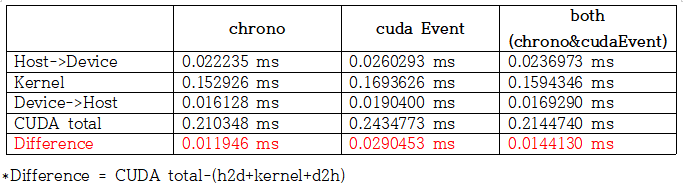



cudaTotal 시간은 디바이스 코드 실행 시간으로 데이터 복사 시간 포함 커널 실행 시간을 포함하고 있다.

정확도 측정을 위해서 cudaTotal시간에서 데이터 복사 시간과 커널 실행 시간의 차를 구해 비교해보았다.

1. chrono로만 측정했을 때 : 0.01194677 ms
2. cudaEvent로만 측정했을 떄: 0.0290453 ms
3. 둘 다 사용했을 떄 : 0.01441303 ms

cudaEvent 시간이 제일 많이 차이가 나는 것으로 보아 아무래도 데이터 복사 시간에서의 차이로 인한 것으로 추측된다.

cudaEvent는 CPU내 데이터 복사 시간은 포함하지 않기 때문이다.

(오버헤드는 측정하지 않아 정확하지 않다. 아직 추측단계이다. 차후 더 정밀한 측정을 고안해보겠다.)

**추가: 만약 chrono 방식에서 동기화가 이루어지지 않는다면?**

In [ ]:
%%cuda
#include "cuda_runtime.h"
#include "device_launch_parameters.h"

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <chrono>
#include <iostream>

// The size of the vector
#define NUM_DATA 1024

// Simple vector sum kernel (Max vector size : 1024)
__global__ void vecAdd(int* _a, int* _b, int* _c) {
	int tID = threadIdx.x;
	_c[tID] = _a[tID] + _b[tID];
}

int main(void)
{

	int* a, * b, * c, * hc;	// Vectors on the host
	int* da, * db, * dc;	// Vectors on the device

	int memSize = sizeof(int) * NUM_DATA;
	printf("%d elements, memSize = %d bytes\n", NUM_DATA, memSize);

	// Memory allocation on the host-side
	a = new int[NUM_DATA]; memset(a, 0, memSize);
	b = new int[NUM_DATA]; memset(b, 0, memSize);
	c = new int[NUM_DATA]; memset(c, 0, memSize);
	hc = new int[NUM_DATA]; memset(hc, 0, memSize);

	// Data generation
	for (int i = 0; i < NUM_DATA; i++) {
		a[i] = rand() % 10;
		b[i] = rand() % 10;
	}


	// Vector sum on host (for performance comparision)
  auto hostStart = std::chrono::high_resolution_clock::now();
	for (int i = 0; i < NUM_DATA; i++)
		hc[i] = a[i] + b[i];
  auto hostEnd = std::chrono::high_resolution_clock::now();
  // 밀리초 단위로 경과 시간 계산 (소수점 포함)
  std::chrono::duration<double, std::milli> hostElapsed = hostEnd - hostStart;


	// Memory allocation on the device-side
	cudaMalloc(&da, memSize); cudaMemset(da, 0, memSize);
	cudaMalloc(&db, memSize); cudaMemset(db, 0, memSize);
	cudaMalloc(&dc, memSize); cudaMemset(dc, 0, memSize);

  auto GPUstart = std::chrono::high_resolution_clock::now();

	// Data copy : Host -> Device
	auto h2dStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(da, a, memSize, cudaMemcpyHostToDevice);
	cudaMemcpy(db, b, memSize, cudaMemcpyHostToDevice);
	auto h2dEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> h2dElapsed = h2dEnd - h2dStart;

	// Kernel call
	auto kernelStart = std::chrono::high_resolution_clock::now();
	vecAdd <<<1, NUM_DATA >>> (da, db, dc);
  auto kernelEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> kernelElapsed = kernelEnd - kernelStart;


	// Copy results : Device -> Host
  auto d2hStart = std::chrono::high_resolution_clock::now();
	cudaMemcpy(c, dc, memSize, cudaMemcpyDeviceToHost);
  auto d2hEnd = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> d2hElapsed = d2hEnd - d2hStart;

	auto GPUend = std::chrono::high_resolution_clock::now();
  std::chrono::duration<double, std::milli> GPUelapsed = GPUend - GPUstart;

	// Release device memory
	cudaFree(da); cudaFree(db); cudaFree(dc);

  // 결과 출력 (밀리초 단위, 소수점 포함)
  std::cout << "Host time: " << hostElapsed.count() << " ms" << std::endl;
  std::cout<<"Host -> Device: " << h2dElapsed.count() << " ms" << std::endl;
  std::cout<<"Kernel: " << kernelElapsed.count() << " ms" << std::endl;
  std::cout<<"Device -> Host: " << d2hElapsed.count() << " ms" << std::endl;
  std::cout<<"CUDA Total Time: " << GPUelapsed.count() << " ms" << std::endl;

	// Check results
	bool result = true;
	for (int i = 0; i < NUM_DATA; i++) {
		if (hc[i] != c[i]) {
			printf("[%d] The result is not matched! (%d, %d)\n"
				, i, hc[i], c[i]);
			result = false;
		}
	}

	if (result)
		printf("GPU works well!\n");

	// Release host memory
	delete[] a; delete[] b; delete[] c;

	return 0;
}

1024 elements, memSize = 4096 bytes
Host time: 0.002958 ms
Host -> Device: 0.022639 ms
Kernel: 0.141264 ms
Device -> Host: 0.019987 ms
CUDA Total Time: 0.184389 ms
GPU works well!



**별 차이가 없다 이유를 생각해보자면?**

**cudaMemcpy** 때문인 것 같다.

cudaMemcpy는 자동으로 동기화로 수행되어서 간단한 연산에서는 굳이 동기화를 명시하지 않아도 동기화로 수행되는 것 같다.